In [1]:
import os
import hashlib
import pandas as pd
from IPython.display import Image

In [2]:
DATASET_DIRECTORIES = [
    "data/yoga-pose-classification/dataset/",
    "data/yoga-posture-dataset/"
]

In [3]:
classes = set()
for dataset_directory in DATASET_DIRECTORIES:
    for dir in os.listdir(dataset_directory):
        if not dir.startswith('.'):
            classes.add(dir)
classes

{'Adho Mukha Svanasana',
 'Adho Mukha Vrksasana',
 'Alanasana',
 'Anjaneyasana',
 'Ardha Chandrasana',
 'Ardha Matsyendrasana',
 'Ardha Navasana',
 'Ardha Pincha Mayurasana',
 'Ashta Chandrasana',
 'Baddha Konasana',
 'Bakasana',
 'Balasana',
 'Bitilasana',
 'Camatkarasana',
 'Dhanurasana',
 'Eka Pada Rajakapotasana',
 'Garudasana',
 'Halasana',
 'Hanumanasana',
 'Malasana',
 'Marjaryasana',
 'Navasana',
 'Padmasana',
 'Parsva Virabhadrasana',
 'Parsvottanasana',
 'Paschimottanasana',
 'Phalakasana',
 'Pincha Mayurasana',
 'Poses.json',
 'Salamba Bhujangasana',
 'Salamba Sarvangasana',
 'Setu Bandha Sarvangasana',
 'Sivasana',
 'Supta Kapotasana',
 'Trikonasana',
 'Upavistha Konasana',
 'Urdhva Dhanurasana',
 'Urdhva Mukha Svsnssana',
 'Ustrasana',
 'Utkatasana',
 'Uttanasana',
 'Utthita Hasta Padangusthasana',
 'Utthita Parsvakonasana',
 'Vasisthasana',
 'Virabhadrasana One',
 'Virabhadrasana Three',
 'Virabhadrasana Two',
 'Vrksasana',
 'adho mukha svanasana',
 'adho mukha vriksasana

In [4]:
print(f"Length of classes: {len(classes)}")

Length of classes: 155


Here we can see there one dataset is capitalized while the other is not. We can also see that the first dataset uses `One`, `Two` and `Three` for sequencing `Virabhadrasana` while the second uses `i`, `ii` and `iii`. Let's make the classes consistent.

In [5]:
renaming = {
    "Virabhadrasana One": "Virabhadrasana i",
    "Virabhadrasana Two": "Virabhadrasana ii",
    "Virabhadrasana Three": "Virabhadrasana iii"
}

for key in renaming:
    os.rename(DATASET_DIRECTORIES[1] + key, DATASET_DIRECTORIES[1] + renaming[key])

In [6]:
# rename subfolders:
# - replace " " with "-"
# - lowercase all letters
for dataset_directory in DATASET_DIRECTORIES:
    for dir in os.listdir(dataset_directory):
        if not dir.startswith('.'):
            old_dir = dir
            new_dir = dir.lower().replace(" ", "-")
            if old_dir != new_dir:
                os.renames(dataset_directory + dir, dataset_directory + new_dir)

As we look closer, we can see that there appears to be a typeo in `yoga-posture-dataset`. `urdhva-mukha-svsnssana` should be `urdhva-mukha-svanasana`. We can confirm that by looking at images from each directory.

In [7]:
potential_same_posture_files = [
    'data/yoga-posture-dataset/urdhva-mukha-svsnssana/File1.png',
    'data/yoga-pose-classification/dataset/urdhva-mukha-svanasana/0-1.png'
]

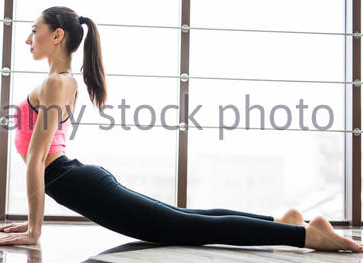

In [8]:
# view image from dataset-smaller/urdhva-mukha-svanssana
Image(filename=potential_same_posture_files[0])

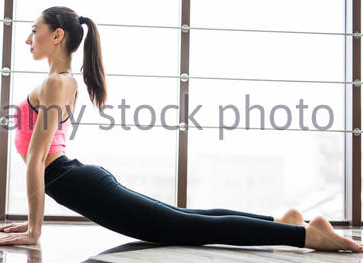

In [9]:
Image(filename=potential_same_posture_files[1])

Not only is this the same pose, but this is the same image! There may be many other cases like this in the data. Luckily there is a solution. File hashing can be used to determine if these files are the same.

Let's determine if these images are exactly the same.

In [10]:
def get_hash_of_file(filename):
    with open(filename,"rb") as f:
        bytes = f.read() # read entire file as bytes
        readable_hash = hashlib.sha256(bytes).hexdigest()
        return readable_hash

In [11]:
for img in potential_same_posture_files:
    print(get_hash_of_file(img))

183e7b3dc6a282ae48918c2cdb38551fb1a8b923c467fac8c43b06356bd5eeab
183e7b3dc6a282ae48918c2cdb38551fb1a8b923c467fac8c43b06356bd5eeab


We don't know how many images are duplicated across these two datasets. While we can remove images that are exactly the same, any images that are the same but have been cropped differently will produce different hashes. So this solution is not perfect but it will work for now.

Before we hash all the files, let's rename the mispelled class name.

In [12]:
os.rename("data/yoga-posture-dataset/urdhva-mukha-svsnssana/", "data/yoga-posture-dataset/urdhva-mukha-svanasana/")

In [13]:
img_counts = {}
for dataset_directory in DATASET_DIRECTORIES:
    for dir in os.listdir(dataset_directory):
        if not dir.startswith('.') and not dir.endswith('.json'):
            if dir in img_counts:
                img_counts[dir] += len(os.listdir(dataset_directory + dir))
            else:
                img_counts[dir] = len(os.listdir(dataset_directory + dir))

images_df = pd.DataFrame.from_dict(img_counts, orient='index', columns=['count_before'])
images_df

,count_before
supta-matsyendrasana,54
agnistambhasana,33
anantasana,43
anjaneyasana,135
eka-pada-rajakapotasana,97
...,...
navasana,18
parsva-virabhadrasana,14
sivasana,20
supta-kapotasana,13


In [14]:
new_directory = "dataset-for-classification/"
os.mkdir(new_directory)

In [34]:
def migrate_files_from_directory(dir_to_move):
    for dir in os.listdir(dir_to_move):
        if not dir.startswith('.') and not dir.endswith('.json'):
            for file in os.listdir(dir_to_move + dir):
                try:
                    # check if dir exists in new directory
                    target_dir = new_directory + dir
                    if not os.path.exists(target_dir):
                        os.mkdir(target_dir)
                    
                    # move file with new hash name to new directory
                    original_file = dir_to_move + dir + "/" + file
                    file_hash = get_hash_of_file(original_file)
                    file_extension = os.path.splitext(file)[1]

                    # move file to new directory
                    os.rename(original_file, new_directory + dir + "/" + file_hash + file_extension)
                except Exception as e:
                    print(f"There was an error with file: {dir_to_move + dir + '/' + file}. {e}")

In [36]:
for dataset_directory in DATASET_DIRECTORIES:
    migrate_files_from_directory(dataset_directory)

In [37]:
# add count after removing duplicates
img_counts = {}
for dir in os.listdir(new_directory):
    if not dir.startswith('.'):
        img_counts[dir] = len(os.listdir(new_directory + dir))

for key in img_counts:
    images_df.loc[key, 'count_after'] = img_counts[key]

images_df.head()

,count_before,count_after
supta-matsyendrasana,54.0,54.0
agnistambhasana,33.0,33.0
anantasana,43.0,43.0
anjaneyasana,135.0,71.0
eka-pada-rajakapotasana,97.0,53.0


In [39]:
images_df["duplicates_removed"] = images_df["count_before"] - images_df["count_after"]
images_df[images_df["duplicates_removed"] > 0]

,count_before,count_after,duplicates_removed
anjaneyasana,135.0,71.0,64.0
eka-pada-rajakapotasana,97.0,53.0,44.0
salamba-sarvangasana,140.0,73.0,67.0
virabhadrasana-i,119.0,64.0,55.0
bakasana,161.0,84.0,77.0
balasana,150.0,79.0,71.0
bhujangasana,73.0,72.0,1.0
bitilasana,181.0,94.0,87.0
camatkarasana,116.0,62.0,54.0
dhanurasana,100.0,54.0,46.0


In [41]:
print(f"Total amount of images before removing duplicates is {images_df['count_before'].sum()}")
print(f"Total amount of images after removing duplicates is {images_df['count_after'].sum()}")
print(f"Total amount of duplicates removed is {images_df['duplicates_removed'].sum()}")
print(f"Total amount of classes is {images_df.shape[0]}")

Total amount of images before removing duplicates is 8752.0
Total amount of images after removing duplicates is 6644.0
Total amount of duplicates removed is 2177.0
Total amount of classes is 119


We just removed over 2,000 images which could really save us from the model overfitting on certain images.

Now looking at the data, there is a new worry. _Too many classes_. We can see that some of these classes have a lot of images while others do not. For the sake of building this model, we will be reducing the number of classes by removing classes that have less than 50 images

<Axes: >

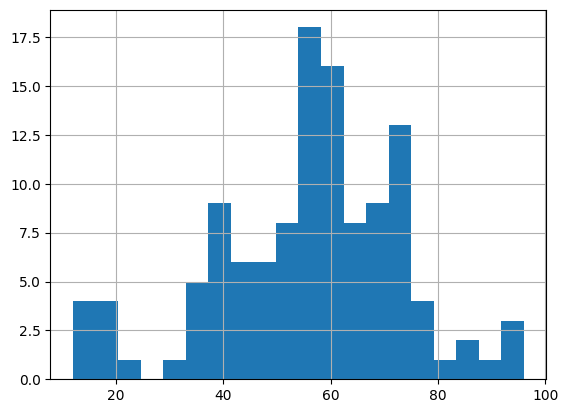

In [51]:
images_df['count_after'].hist(bins=20)

<Axes: >

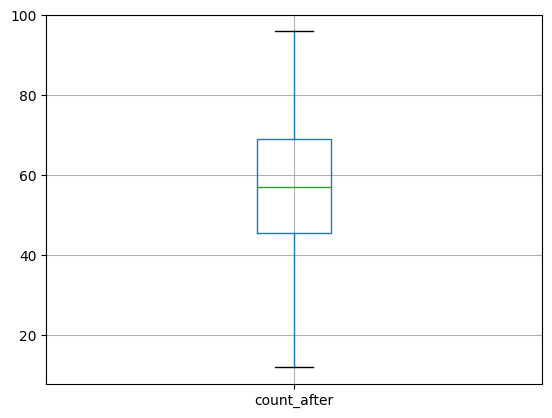

In [44]:
images_df.boxplot(column=['count_after'])

In [47]:
print(f"Average images per class {images_df['count_after'].mean()}")
print(f"Median images per class {images_df['count_after'].median()}")


Average images per class 55.831932773109244
Median images per class 57.0


In [57]:
print(f"Amount of clases with less than 50 images is {(images_df[images_df['count_after'] < 50]).shape[0]}")
print(f"Amount of clases with 50 or more images is {(images_df[images_df['count_after'] >= 50]).shape[0]}")

Amount of clases with less than 50 images is 36
Amount of clases with 50 or more images is 83


We've chosen a somewhat arbitrary cutoff of 50 images. It accounts for nearly 70% of all the classes featured across the datasets.

In [60]:
# move the small classes to a new directory
small_classes_dir = "dataset-small-classes/"
os.mkdir(small_classes_dir)

small_classes = images_df[images_df['count_after'] < 50].index.tolist()
for dir in small_classes:
    os.rename(new_directory + dir, small_classes_dir + dir)